                       ds     y unique_id
0     2016-11-09 13:03:00   0.0   garage1
1     2016-11-09 13:04:00   0.0   garage1
2     2016-11-09 13:05:00   0.0   garage1
3     2016-11-09 13:06:00   0.0   garage1
4     2016-11-09 13:07:00   0.0   garage1
...                   ...   ...       ...
12892 2016-11-18 11:55:00  82.0   garage1
12893 2016-11-18 11:56:00  79.0   garage1
12894 2016-11-18 11:57:00  84.0   garage1
12895 2016-11-18 11:58:00  88.0   garage1
12896 2016-11-18 11:59:00  87.0   garage1

[12897 rows x 3 columns]


<Axes: xlabel='ds'>

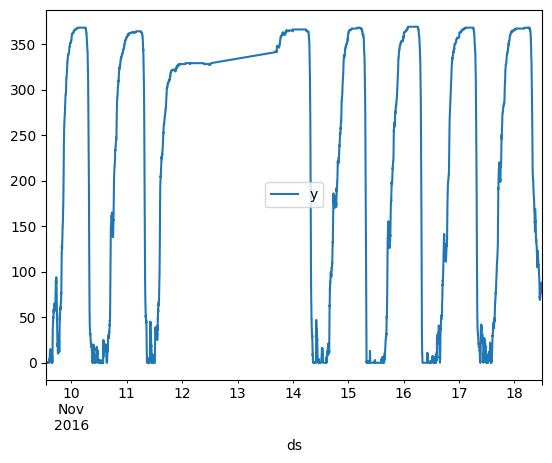

In [137]:
# Load data
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

path1 = 'Sign1_full_fitted.csv'
data1 = pd.read_csv(path1, usecols=[0,1], header=0)
data1['ts'] = pd.to_datetime(data1['ts'])
data1['unique_id'] = 'garage1'
data1 = data1.rename(columns={'ts': 'ds', 'y1': 'y'})
print(data1)
data1.plot(x = 'ds', y = 'y')

                       ds      y unique_id
0     2016-11-09 13:03:00    0.0   garage1
1     2016-11-09 13:04:00    0.0   garage1
2     2016-11-09 13:05:00    0.0   garage1
3     2016-11-09 13:06:00    0.0   garage1
4     2016-11-09 13:07:00    0.0   garage1
...                   ...    ...       ...
12892 2016-11-18 11:55:00  340.0   garage1
12893 2016-11-18 11:56:00  340.0   garage1
12894 2016-11-18 11:57:00  336.0   garage1
12895 2016-11-18 11:58:00  334.0   garage1
12896 2016-11-18 11:59:00  335.0   garage1

[12897 rows x 3 columns]


<Axes: xlabel='ds'>

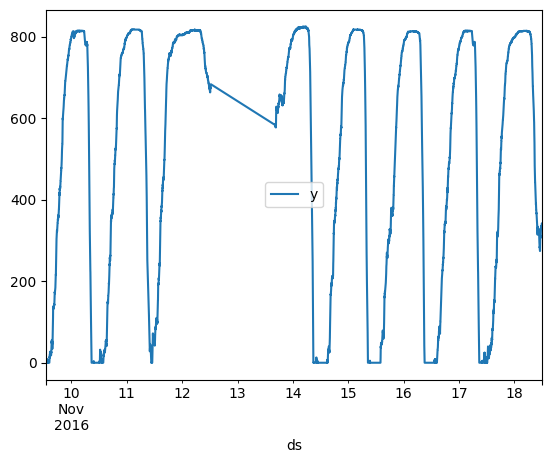

In [138]:
path2 = 'Sign12_full_fitted.csv'
data2 = pd.read_csv(path2, usecols=[0,1], header=0)
data2['ts'] = pd.to_datetime(data2['ts'])
data2['unique_id'] = 'garage1'
data2 = data2.rename(columns={'ts': 'ds', 'y12': 'y'})
print(data2)
data2.plot(x = 'ds', y = 'y')

In [139]:
path4 = 'Sign14_full_fitted.csv'
data4 = pd.read_csv(path4, usecols=[0,1], header=0)
print(data4)

                        ts    y14
0      2016-11-09 13:03:00   20.0
1      2016-11-09 13:04:00   20.0
2      2016-11-09 13:05:00   20.0
3      2016-11-09 13:06:00   16.0
4      2016-11-09 13:07:00   16.0
...                    ...    ...
12892  2016-11-18 11:55:00  333.0
12893  2016-11-18 11:56:00  334.0
12894  2016-11-18 11:57:00  335.0
12895  2016-11-18 11:58:00  336.0
12896  2016-11-18 11:59:00  335.0

[12897 rows x 2 columns]


In [140]:
train = data1.loc[:,:]
valid = data2.loc[:,:]

In [141]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

models = [RandomForestRegressor(random_state=0, n_estimators=100),
          ExtraTreesRegressor(random_state=0, n_estimators=100)]

In [142]:
from numba import njit

@njit
def diff(x, lag):
    x2 = np.full_like(x, np.nan)
    for i in range(lag, len(x)):
        x2[i] = x[i] - x[i-lag]
    return x2

In [143]:
from window_ops.rolling import rolling_mean
from mlforecast import MLForecast

model = MLForecast(models=models,
                   freq='MIN',
                   lags=[1,7,14],
                   lag_transforms={
                       1: [(rolling_mean, 3), (rolling_mean, 7), (rolling_mean, 28), (diff, 1), (diff, 7)],
                   }
                  )

In [144]:
model.fit(train, id_col='unique_id', time_col='ds', target_col='y', static_features=[])

p = model.predict(horizon=90, dynamic_dfs=[valid[['unique_id', 'ds']]])
p = p.merge(valid[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'], how='left')

In [145]:
model.preprocess(train, id_col='unique_id', time_col='ds', target_col='y', static_features=[])


,ds,y,unique_id,lag1,lag7,lag14,rolling_mean_lag1_window_size3,rolling_mean_lag1_window_size7,rolling_mean_lag1_window_size28,diff_lag1_lag1,diff_lag1_lag7
28,2016-11-09 13:31:00,0.0,garage1,0.0,0.0,0.0,0.000000,0.142857,0.035714,0.0,0.0
29,2016-11-09 13:32:00,0.0,garage1,0.0,0.0,0.0,0.000000,0.142857,0.035714,0.0,0.0
30,2016-11-09 13:33:00,0.0,garage1,0.0,1.0,0.0,0.000000,0.142857,0.035714,0.0,0.0
31,2016-11-09 13:34:00,0.0,garage1,0.0,0.0,0.0,0.000000,0.000000,0.035714,0.0,-1.0
32,2016-11-09 13:35:00,0.0,garage1,0.0,0.0,0.0,0.000000,0.000000,0.035714,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
12892,2016-11-18 11:55:00,82.0,garage1,81.0,82.0,87.0,82.000000,82.000000,84.392857,-2.0,-2.0
12893,2016-11-18 11:56:00,79.0,garage1,82.0,81.0,88.0,82.000000,82.000000,84.321429,1.0,0.0
12894,2016-11-18 11:57:00,84.0,garage1,79.0,82.0,88.0,80.666667,81.714286,84.142857,-3.0,-2.0
12895,2016-11-18 11:58:00,88.0,garage1,84.0,83.0,86.0,81.666667,82.000000,84.178571,5.0,2.0


<Axes: title={'center': 'RandomForestRegressor Feature Importance'}, xlabel='Features', ylabel='Importance'>

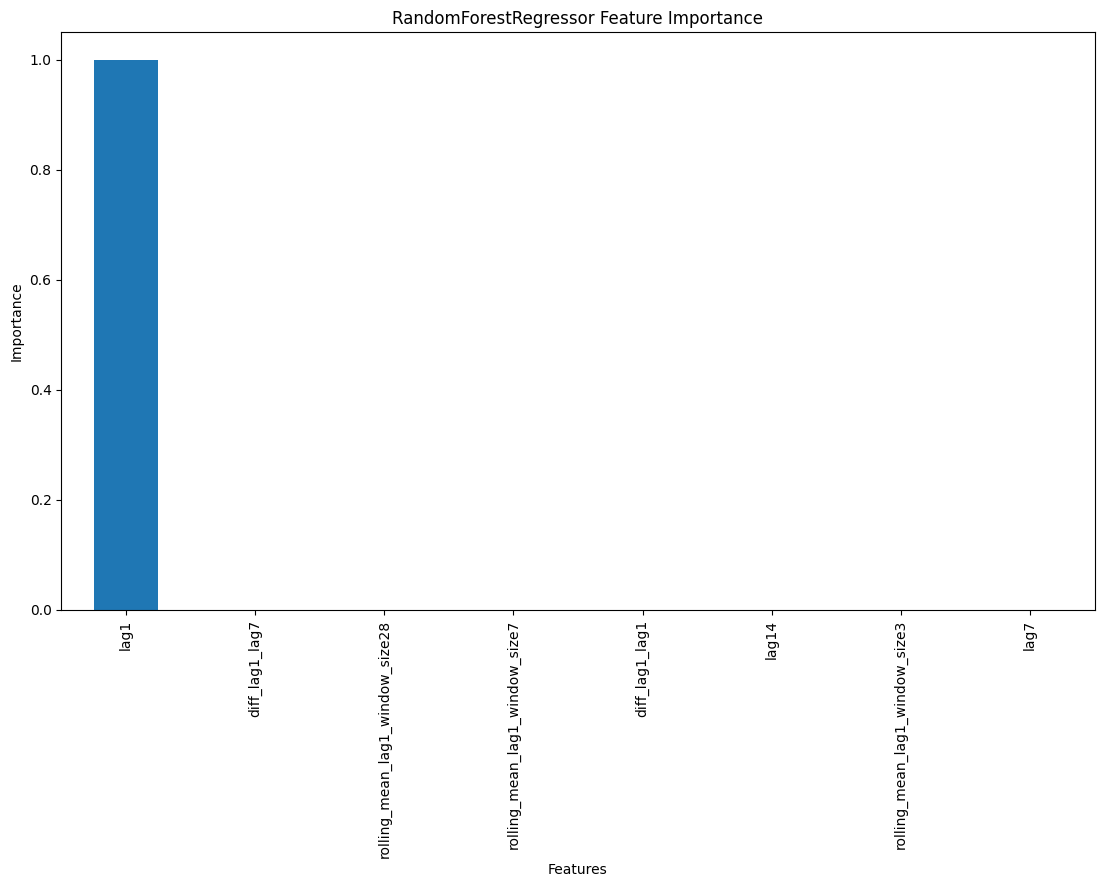

In [147]:
pd.Series(model.models_['RandomForestRegressor'].feature_importances_, index=model.ts.features_order_).sort_values(ascending=False).plot.bar(
            figsize=(1280/96,720/96), title='RandomForestRegressor Feature Importance', xlabel='Features', ylabel='Importance')

<Axes: title={'center': 'ExtraTreeRegressor Feature Importance'}, xlabel='Features', ylabel='Importance'>

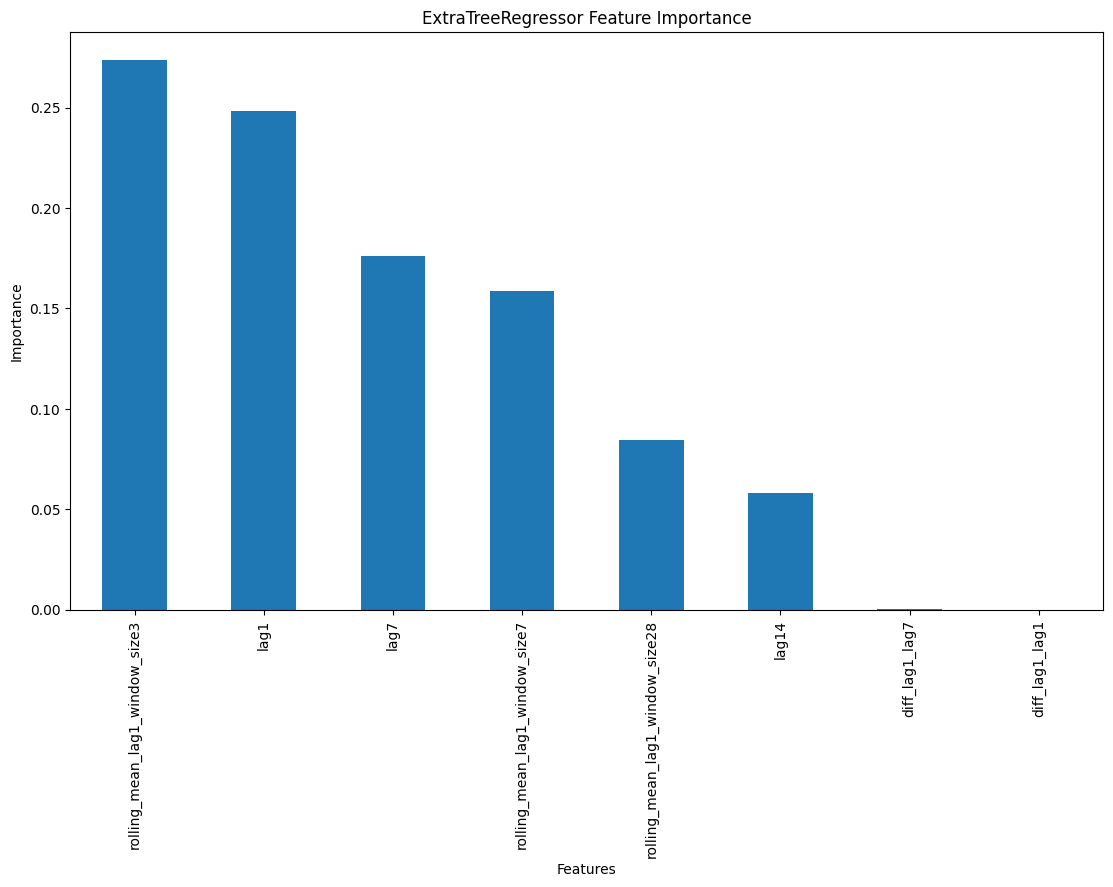

In [149]:
pd.Series(model.models_['ExtraTreesRegressor'].feature_importances_, index=model.ts.features_order_).sort_values(ascending=False).plot.bar(
            figsize=(1280/96,720/96), title='ExtraTreeRegressor Feature Importance', xlabel='Features', ylabel='Importance')